## Kaggle Competition | Titanic Machine Learning from Disaster
Competiton Homepage- https://www.kaggle.com/c/titanic

### Outline
#### 0. About the Dataset
#### 1. Exploratory Data Analysis
#### 2. Feature Engineering
#### 3. Machine Learning Models
#### 4. Upload the prediction and get up on leaderboard

# Ground Zero - What is this Dataset about?
## 0.1 Introduction
Predicting what kind of people were likely to survive

## Importing some essential Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold

# 0.2. Loading the Dataset
* Training set has 891 rows and test set has 418 rows.
* Training set have 12 features and test set have 11 features.
* One extra feature in the training set is Survived feature, which is the class of a row.

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418



In [5]:
print(df_train.columns)
print(df_test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


<font size="2">
    <h1> 1. Exploratory Data Analysis </h1>
    <h2> 1.1. Overview </h2>

> PassengerId feature is the unique id of the row and it doesn't have any effect on Survived.
*  Survived feature is binary (0 or 1) </br>
    * 1 = Survived </br>
    * 0 = Not Survived
* Pclass (Passenger Class) feature is the socio-economic status of the passenger. It is a categorical ordinal feature which has 3 unique values (1, 2 or 3);
    * 1 = Upper Class </br>
    * 2 = Middle Class</br>
    * 3 = Lower Class
* Name, Sex and Age features are self-explanatory.
* SibSp feature is the total number of the passengers' siblings and spouse.
* Parch feature is the total number of the passengers' parents and children.
* Ticket feature is the ticket number of the passenger.
* Fare feature is the passenger fare.
* Cabin feature is the cabin number of the passenger.
* Embarked is port of embarkation. It is a categorical feature and it has 3 unique values (C, Q or S);
    * C = Cherbourg </br>
    * Q = Queenstown </br>
    * S = Southampton
</font>

In [6]:
def columns_isNull(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

print('Missing Values in Training DataSet out of 891 passengeers:\n')
columns_isNull(df_train)

Missing Values in Training DataSet out of 891 passengeers:

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2




In [7]:
print('Missing Values in Testing DataSet out of 418 passengers:\n')
columns_isNull(df_test)

Missing Values in Testing DataSet out of 418 passengers:

PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




Merging all data together: **WHY???**
* Filled data may overfit to separate training or test sets
* Amount of missing values is large in Cabin feature

In [8]:
df_concat = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [9]:
dfs = [df_train, df_test]

#### Missing Values, how many??

## 1.2. Dealing with Missing Values, How???

### 1.2.1. Working on Embarked Column
* Categorical Feature
* 2 missing values in all

Let's see who are they?

In [10]:
df_concat[df_concat['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [11]:
df_embarked =  df_concat[df_concat['Pclass'] ==1].groupby(['Embarked', 'Pclass','Sex'])['Fare'].median().drop(
    columns=['Survived', 'Age', 'SibSp', 'Parch', 'Cabin', 'Name', 'Ticket']).transpose()
df_embarked.head()

Embarked  Pclass  Sex   
C         1       female    83.15830
                  male      62.66875
Q         1       female    90.00000
                  male      90.00000
S         1       female    78.85000
Name: Fare, dtype: float64

On checking Google.com:
* Mrs. George Nelson (Martha Evelyn) embarked from S (Southampton) with her maid Amelie Icard,
* This is the information needed and case closed for Embarked feature.

In [12]:
# Filling the missing values in Embarked with S
df_concat['Embarked'] = df_concat['Embarked'].fillna('S')

<font size="2">
    <h3> 1.2.2 Working on Age Column <h3>
        <li>How do we fill the not present age fields?</li>

<font size="2">
    <li> Median age of whole dataset? </li>
    <li> No, because it's not close to accurate </li>
    <li> Median age of a group? </li>
Let's see the correlation and decide which group to choose
</font>

In [13]:
df_concat_corr = df_concat.corr().abs().unstack().sort_values(kind="selectionsort", ascending=False).reset_index()
df_concat_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_concat_corr[df_concat_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
10,Age,Pclass,0.408106
18,Age,SibSp,0.243699
22,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
42,Age,PassengerId,0.028814


Let's see further grouping if possible with each sex group?


In [14]:
age_by_pclass_sex = df_concat.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_concat['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


The median ages above are used for filling the missing values in Age feature.

In [15]:
df_concat['Age'] = df_concat.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

### 1.2.3. Working on Cabin Column

In [16]:
df_concat['Deck'] = df_concat['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [17]:
df_concat_decks_plcass = df_concat.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                'Fare', 'Embarked', 'Cabin', 'Name', 'Ticket']).rename(columns={'PassengerId': 'Count'}).transpose()
df_concat_decks_plcass

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

<font size = "2">
    <li>100% of A, B and C decks are 1st class passengers.</li>
    <li>Deck D has 87% 1st class and 13% 2nd class passengers.</li>
    <li>Deck E has 83% 1st class, 10% 2nd class and 7% 3rd class passengers.</li>
    <li> Deck F has 62% 2nd class and 38% 3rd class passengers.</li>
    <li>100% of G deck are 3rd class passengers.</li>

In [18]:
df_concat_decks_survived = df_concat.groupby(['Deck', 'Survived']).count().drop(columns=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 
                        'Fare', 'Embarked', 'Cabin', 'Name', 'Ticket']).rename(columns={'PassengerId': 'Count'}).transpose()
df_concat_decks_survived

Deck       A       B       C       D       E       F       G        M        T
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0 0.0
Count      8   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206   1

* Deck B, C, D and E have the highest survival rates and mostly occupied by 1st class passengers
* M has the lowest survival rate which is mostly occupied by 2nd and 3rd class passengers

<font size ="2">
    <h1>Can we group some decks?</h1>

<li>A, B and C decks- because all of them have only 1st class passengers | labelling them as ABC </li>
<li>D and E decks- because both of them have similar passenger class distribution and same survival rate | labelling them as DE </li>
</font>






In [19]:
idx = df_concat[df_concat['Deck'] == 'T'].index
df_concat.loc[idx, 'Deck'] = 'A'

In [20]:
df_concat['Deck'] = df_concat['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_concat['Deck'] = df_concat['Deck'].replace(['D', 'E'], 'DE')

df_concat['Deck'].value_counts()

M      1014
ABC     182
DE       87
F        21
G         5
Name: Deck, dtype: int64

In [21]:
df_concat.drop(['Cabin'], inplace=True, axis=1)

### 1.2.4. Working on Fare Column


In [22]:
df_concat_corr_fare = df_concat.corr().abs().unstack().sort_values(kind="selectionsort", ascending=False).reset_index()
df_concat_corr_fare.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_concat_corr_fare[df_concat_corr_fare['Feature 1'] == 'Fare']

,Feature 1,Feature 2,Correlation Coefficient
5,Fare,Fare,1.000000
8,Fare,Pclass,0.558629
16,Fare,Survived,0.257307
18,Fare,Parch,0.221539
21,Fare,Age,0.200039
24,Fare,SibSp,0.160238
40,Fare,PassengerId,0.031428


In [23]:
df_concat[df_concat['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,M


In [24]:
med_fare = df_concat.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
df_concat['Fare'] = df_concat['Fare'].fillna(med_fare)

<font size="2">
    <h2>Any more missing values?? </h2>
Let's check!
</font>

In [25]:
df_train, df_test = df_concat.loc[:890], df_concat.loc[891:].drop(['Survived'], axis=1)

In [26]:
print('Missing Values in Training DataSet:\n')
columns_isNull(df_train)

Missing Values in Training DataSet:

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




In [27]:
print('Missing Values in Testing DataSet:\n')
columns_isNull(df_train)

Missing Values in Testing DataSet:

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




# YAY!!!!!! Victory!!

## 1.3 Survival Analysis

In [28]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


## 1.4 Correlation Analysis

Training Dataset


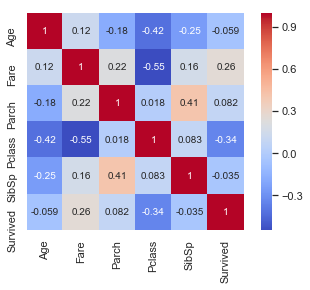

In [29]:
print("Training Dataset")
sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), annot=True, square=True, cmap='coolwarm')

Testing Dataset


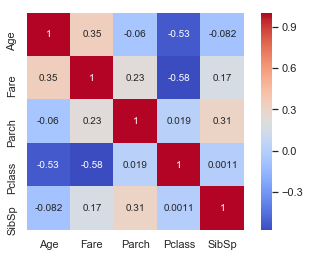

In [30]:
print("Testing Dataset")
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), annot=True, square=True, cmap='coolwarm')

<font size ="2">
    <h1> Small Recap </h1>
    <li> Worked on combined data to avoid overfitting problem </li>
<li> Missing values problem solved for Age, Cabin, Embarked and Fare</li>
<li> Created a new feature, Deck, and dropped Cabin feature at the Exploratory Data Analysis part</li>
<li> We found correlation to create new features with feature transformation and interaction.</li>
</font>

In [31]:
df_concat = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
df_concat.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450



# 2. Feature Engineering
## 2.1 Binning of Continuous Variables:

### 2.1.1 Age

In [32]:
df_concat['Age'] = pd.qcut(df_concat['Age'], 10)

In [33]:
df_concat.groupby(['Age']).count().transpose().columns

CategoricalIndex([(0.169, 16.0],  (16.0, 21.0],  (21.0, 22.0],  (22.0, 25.0],
                   (25.0, 26.0],  (26.0, 29.5],  (29.5, 34.0],  (34.0, 40.0],
                   (40.0, 48.0],  (48.0, 80.0]],
                 categories=[(0.169, 16.0], (16.0, 21.0], (21.0, 22.0], (22.0, 25.0], (25.0, 26.0], (26.0, 29.5], (29.5, 34.0], (34.0, 40.0], ...], ordered=True, name='Age', dtype='category')

### 2.1.2 Fare


In [34]:
df_concat['Fare'] = pd.qcut(df_concat['Fare'], 10)

In [35]:
df_concat.groupby(['Fare']).count().transpose().columns

CategoricalIndex([  (-0.001, 7.57],    (7.57, 7.854],    (7.854, 8.05],
                      (8.05, 10.5],   (10.5, 14.454], (14.454, 21.558],
                   (21.558, 26.82],  (26.82, 41.579],  (41.579, 78.02],
                  (78.02, 512.329]],
                 categories=[(-0.001, 7.57], (7.57, 7.854], (7.854, 8.05], (8.05, 10.5], (10.5, 14.454], (14.454, 21.558], (21.558, 26.82], (26.82, 41.579], ...], ordered=True, name='Fare', dtype='category')

<font size ="2">
    <h2> 2.2 Family Feature </h2>
<li>Family_Size is created by adding SibSp, Parch and 1. </li>
<li> Adding 1 at the end, is the current passenger.</li>
<li>Family Size = 1 are labeled as Alone.</li>
<li>Family Size = 2-4 are labeled as Small.</li>
<li>Family Size = 5-6 are labeled as Medium.</li>
<li>Family Size = 7-11 are labeled as Large</li>

In [36]:
df_concat['Family_Size'] = df_concat['SibSp'] + df_concat['Parch'] + 1

In [37]:
family_map = {1: 'A', 2: 'S', 3: 'S', 4: 'S', 5: 'M', 6: 'M', 7: 'L', 8: 'L', 11: 'L'}
df_concat['Family_Size_Grouped'] = df_concat['Family_Size'].map(family_map)

## 2.3 Tickets Feature
* Grouping tickets up by their frequencies.

* How is this feature different than Family_Size? 
    * Other relations weren't counted as family, but they used the same ticket.
    * Not grouped like Family_Size because create the same feature with perfect correlation

In [38]:
df_concat['Ticket_Frequency'] = df_concat.groupby('Ticket')['Ticket'].transform('count')

## 2.4 Title
* Title is created by extracting the prefix before the Name feature values.

In [39]:
df_concat['Title'] = df_concat['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

## 2.5 Is Married??

* Using the title feature of Mrs. as they have highest survival rate among other female titles


In [40]:
df_concat['Is_Married'] = 0
df_concat['Is_Married'].loc[df_concat['Title'] == 'Mrs'] = 1

Grouping Remaining Titles 
* Kept Master and Mr. as Sepertate Title
* Female Titles grouped as Female
* Remaining all tagged as Miscellaneous

In [41]:
df_concat['Title'] = df_concat['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Female')
df_concat['Title'] = df_concat['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Miscellaneous')

### 2.5. Feature Transformation 

<img src="https://miro.medium.com/max/700/0*T5jaa2othYfXZX9W.">

### 2.5.1. Label Encoding the Non-Numerical Features
* Age and Fare features are category type. They are converted to numerical type with LabelEncoder.

In [42]:
df_train = df_concat.loc[:890]
df_test = df_concat.loc[891:]
dfs = [df_train, df_test]

non_numeric_features = ['Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

### 2.5.2. One-Hot Encoding the Categorical Features
* The categorical features (Pclass, Sex, Deck, Embarked, Title, Family_Size_Grouped) are converted to one-hot encoded features with OneHotEncoder.
* Binary Values



In [43]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

## Small Recap
* Age and Fare features are binned. Binning helped dealing with outliers and it revealed some homogeneous groups in those features.
* Family_Size is created by adding Parch and SibSp features and 1.
* Ticket_Frequency is created by counting the occurence of Ticket values.
* Name feature is very useful. Title and Is_Married features are created from the title prefix in the names.
* Finally, the non-numeric type features are label encoded and categorical features are one-hot encoded.
* Created 3 new features (Family_Size, Title, Is_Married) and dropped the unncessary features after encoding.

In [44]:
df_concat = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
drop_cols = ['Deck', 'Embarked', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title']

df_concat.drop(columns=drop_cols, inplace=True)

df_concat.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Deck_5,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,...,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2,1.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1,1.0,0.0,0.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2,1.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0


In [45]:
df_concat.columns

Index(['Age', 'Deck_1', 'Deck_2', 'Deck_3', 'Deck_4', 'Deck_5', 'Embarked_1',
       'Embarked_2', 'Embarked_3', 'Family_Size_Grouped_1',
       'Family_Size_Grouped_2', 'Family_Size_Grouped_3',
       'Family_Size_Grouped_4', 'Fare', 'Is_Married', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_1', 'Sex_2', 'Ticket_Frequency', 'Title_1', 'Title_2',
       'Title_3', 'Title_4'],
      dtype='object')



---


# 3. Machine Learning



In [46]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 25)
y_train shape: (891,)
X_test shape: (418, 25)


## 3.1. Models
* Created a RandomForestClassifier's for k-fold cross validation.

<img src="https://miro.medium.com/max/700/1*rgba1BIOUys7wQcXcL4U5A.png">

In [47]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=50,
                                           n_jobs=-1)

In [48]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_concat.columns)

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    
    # Fitting the model
    single_best_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = single_best_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = single_best_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = single_best_model.feature_importances_
        
    oob += single_best_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, single_best_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1 OOB Score: 0.8342696629213483

Fold 2 OOB Score: 0.8328651685393258

Fold 3 OOB Score: 0.8260869565217391

Fold 4 OOB Score: 0.8274894810659187

Fold 5 OOB Score: 0.8417366946778712

Average OOB Score: 0.8324895927452407


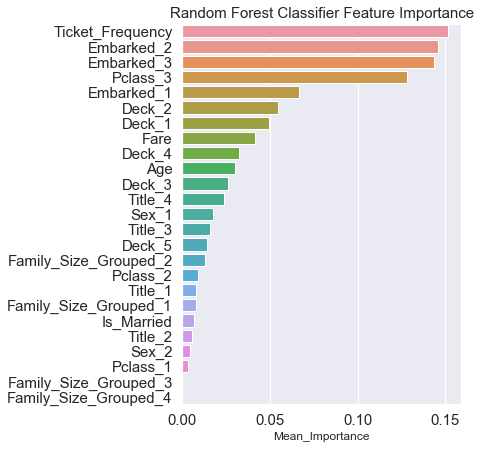

In [49]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(5, 7))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Feature Importance', size=15)

plt.show()

# 3.3 Submission To Kaggle

In [50]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)


In [51]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('predictor.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


# Scope
* Start experimenting and hyperparameter tuning.
* Deal with outliers
* Recursive Feature Selections(RFEs)
* Different Models
* Ensemble Learning


# Credits :
- Jupyter notebook interactive presentation | Damian Avila | [https://github.com/damianavila/RISE]
- [Towards Data Science](https://towardsdatascience.com/)
- Kaggle Kernels - https://www.kaggle.com/c/titanic/kernels
- [KDNuggets](https://www.kdnuggets.com/)

# THANK YOU!!

- Women Who Code - https://www.womenwhocode.com/
- Lead of WWC Python Track- Emily Rymer and Liliana Torres

# Find this Notebook??
- https://github.com/kunal-lalwani/WWC-Python-Webinar-Titanic

<img src="https://i.imgur.com/CfSwf.jpg">

## Any Questions??

# My Information

- LinkedIn - [linkedin.com/in/kunal-lalwani](https://www.linkedin.com/in/kunal-lalwani/)
- Email - kunal4.lalwani@gmail.com
- Website - [kunal-lalwani.github.io](https://kunal-lalwani.github.io/)

# Follow Us:
- Website - https://www.womenwhocode.com/python
- Slack and Social Media - https://linktr.ee/wwcodepython